# Gemstone Price Prediction of Germany from Co-Learning Lounge
### Problem Statement
You are hired by a company Gem Stones co ltd, which is a cubic zirconia manufacturer. You are provided with the dataset containing the prices and other attributes of almost 27,000 cubic zirconia (which is an inexpensive diamond alternative with many of the same qualities as a diamond). The company is earning different profits on different prize slots. You have to help the company in predicting the price for the stone on the basis of the details given in the dataset so it can distinguish between higher profitable stones and lower profitable stones so as to have a better profit share. Also, provide them with the best 5 attributes that are most important.

Link: https://www.kaggle.com/datasets/colearninglounge/gemstone-price-prediction

### 1 Import of Data and Required Packages

In [1]:
# Basic Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

# Modelling
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import warnings

Import the CSV Data as Pandas DataFrame

In [2]:
df = pd.read_csv('data/gemstonedataset.csv')
df.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,x,y,z,price
0,1,0.30,Ideal,E,SI1,62.1,58.0,4.27,4.29,2.66,499
1,2,0.33,Premium,G,IF,60.8,58.0,4.42,4.46,2.70,984
2,3,0.90,Very Good,E,VVS2,62.2,60.0,6.04,6.12,3.78,6289
3,4,0.42,Ideal,F,VS1,61.6,56.0,4.82,4.80,2.96,1082
4,5,0.31,Ideal,F,VVS1,60.4,59.0,4.35,4.43,2.65,779


In [3]:
# Let's find out a bit more about the variables in the dataframe:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26967 entries, 0 to 26966
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  26967 non-null  int64  
 1   carat       26967 non-null  float64
 2   cut         26967 non-null  object 
 3   color       26967 non-null  object 
 4   clarity     26967 non-null  object 
 5   depth       26270 non-null  float64
 6   table       26967 non-null  float64
 7   x           26967 non-null  float64
 8   y           26967 non-null  float64
 9   z           26967 non-null  float64
 10  price       26967 non-null  int64  
dtypes: float64(6), int64(2), object(3)
memory usage: 2.3+ MB


Check Missing values

In [4]:
df.isna().sum()

Unnamed: 0      0
carat           0
cut             0
color           0
clarity         0
depth         697
table           0
x               0
y               0
z               0
price           0
dtype: int64

There are 697 missing values in the depth column

In [5]:
# Numerical columns
num_cols = list(df._get_numeric_data().columns)
print(num_cols)

['Unnamed: 0', 'carat', 'depth', 'table', 'x', 'y', 'z', 'price']


In [6]:
# Categorical columns
cat_cols = set(df.columns) - set(num_cols)
print(cat_cols)

{'color', 'clarity', 'cut'}


In [10]:
# Drop the rows with null values
df = df.dropna()

# Display the total number of null values in the resulting dataframe
df.isna().sum()

#It's also a good idea to drop duplicate rows:
df = df.drop_duplicates(keep='first')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26236 entries, 0 to 26966
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    26236 non-null  float64
 1   cut      26236 non-null  object 
 2   color    26236 non-null  object 
 3   clarity  26236 non-null  object 
 4   depth    26236 non-null  float64
 5   table    26236 non-null  float64
 6   x        26236 non-null  float64
 7   y        26236 non-null  float64
 8   z        26236 non-null  float64
 9   price    26236 non-null  int64  
dtypes: float64(6), int64(1), object(3)
memory usage: 2.2+ MB


### 2 Preparing X and Y variables and Transformation

In [11]:
X = df.drop(columns=['price'],axis=1)
X.head()

,carat,cut,color,clarity,depth,table,x,y,z
0,0.30,Ideal,E,SI1,62.1,58.0,4.27,4.29,2.66
1,0.33,Premium,G,IF,60.8,58.0,4.42,4.46,2.70
2,0.90,Very Good,E,VVS2,62.2,60.0,6.04,6.12,3.78
3,0.42,Ideal,F,VS1,61.6,56.0,4.82,4.80,2.96
4,0.31,Ideal,F,VVS1,60.4,59.0,4.35,4.43,2.65


In [12]:
y = df['price']
y

0         499
1         984
2        6289
3        1082
4         779
         ... 
26962    5408
26963    1114
26964    1656
26965     682
26966    5166
Name: price, Length: 26236, dtype: int64

In [13]:
# Define which columns should be ordinal-encoded and which should be scaled
categorical_cols = X.select_dtypes(include='object').columns
numerical_cols = X.select_dtypes(exclude='object').columns
            
# Define the custom ranking for each ordinal variable
cut_categories = ['Fair', 'Good', 'Very Good','Premium','Ideal']
color_categories = ['D', 'E', 'F', 'G', 'H', 'I', 'J']
clarity_categories = ['I1','SI2','SI1','VS2','VS1','VVS2','VVS1','IF']

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder,StandardScaler

# Numerical Pipeline
num_pipeline = Pipeline(
                steps = [
                ('imputer',SimpleImputer(strategy='median')),
                ('scaler',StandardScaler())                
                ]
            )

# Categorical Pipeline
cat_pipeline = Pipeline(
                steps=[
                ('imputer',SimpleImputer(strategy='most_frequent')),
                ('ordinal_encoder',OrdinalEncoder(categories=[cut_categories,color_categories,clarity_categories])),
                ('scaler',StandardScaler())
                ]
            )

preprocessor = ColumnTransformer(
                [
                ('num_pipeline',num_pipeline,numerical_cols),
                ('cat_pipeline',cat_pipeline,categorical_cols)
                ]
            )

In [15]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(X,y,test_size=0.2,random_state=42)

In [16]:
xtrain = pd.DataFrame(preprocessor.fit_transform(xtrain),columns=preprocessor.get_feature_names_out())
xtest = pd.DataFrame(preprocessor.transform(xtest),columns=preprocessor.get_feature_names_out())

In [17]:
preprocessor.get_feature_names_out()

array(['num_pipeline__carat', 'num_pipeline__depth',
       'num_pipeline__table', 'num_pipeline__x', 'num_pipeline__y',
       'num_pipeline__z', 'cat_pipeline__cut', 'cat_pipeline__color',
       'cat_pipeline__clarity'], dtype=object)

### 3 Create an Evaluate Function to give all metrics after model Training

In [18]:
xtrain.head()

,num_pipeline__carat,num_pipeline__depth,num_pipeline__table,num_pipeline__x,num_pipeline__y,num_pipeline__z,cat_pipeline__cut,cat_pipeline__color,cat_pipeline__clarity
0,-1.019216,0.595334,0.694676,-1.237289,-1.213397,-1.192048,0.084332,-1.535123,-0.034313
1,-0.977284,-0.319299,-0.650776,-1.139646,-1.077486,-1.149170,0.979159,-1.535123,-0.641538
2,-1.103079,-0.389655,0.246192,-1.397069,-1.306836,-1.406436,0.979159,-0.358661,1.180136
3,-0.977284,-0.460012,0.694676,-1.130770,-1.111464,-1.177755,0.084332,0.229569,-0.641538
4,0.867719,-0.389655,0.246192,0.999622,1.003654,0.966128,-0.810494,1.406030,0.572911


In [19]:
xtest.head()

,num_pipeline__carat,num_pipeline__depth,num_pipeline__table,num_pipeline__x,num_pipeline__y,num_pipeline__z,cat_pipeline__cut,cat_pipeline__color,cat_pipeline__clarity
0,0.029081,0.384265,0.246192,0.245108,0.179692,0.265793,0.084332,-1.535123,0.572911
1,-0.474101,-1.656071,0.246192,-0.269737,-0.295997,-0.463128,0.084332,-0.946892,-0.641538
2,-0.578931,0.173196,-1.099260,-0.500529,-0.457391,-0.463128,0.979159,0.229569,-0.034313
3,-1.040181,0.595334,-0.650776,-1.281673,-1.255870,-1.234925,0.979159,0.817800,1.787360
4,0.469366,1.298898,-0.202292,0.582420,0.578931,0.766032,-1.705321,0.229569,-0.034313


### 4 Results of the models

In [20]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

Traaining various models

In [21]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(), 
    "CatBoosting Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor()
}
model_list = []
r2_list =[]

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(xtrain, ytrain.values.flatten()) # Train model

    # Make predictions
    y_train_pred = model.predict(xtrain)
    y_test_pred = model.predict(xtest)
    
    # Evaluate Train and Test dataset
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(ytrain, y_train_pred)

    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(ytest, y_test_pred)

    
    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)
    
    print('='*35)
    print('\n')

Linear Regression
Model performance for Training set
- Root Mean Squared Error: 1223.8485
- Mean Absolute Error: 812.8502
- R2 Score: 0.9075
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 1201.9533
- Mean Absolute Error: 798.6421
- R2 Score: 0.9100


Lasso
Model performance for Training set
- Root Mean Squared Error: 1223.9047
- Mean Absolute Error: 814.0470
- R2 Score: 0.9074
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 1202.0304
- Mean Absolute Error: 799.8747
- R2 Score: 0.9100


Ridge
Model performance for Training set
- Root Mean Squared Error: 1223.8494
- Mean Absolute Error: 813.0511
- R2 Score: 0.9075
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 1201.9533
- Mean Absolute Error: 798.8483
- R2 Score: 0.9100


K-Neighbors Regressor
Model performance for Training set
- Root Mean Squared Error: 627.7892
- Mean Absolute Error: 328.7419
- R2 Sco

Plot y_pred and y_test

In [27]:
df_results = pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name', 'R2_Score']).sort_values(by=["R2_Score"],ascending=False)
df_results

,Model Name,R2_Score
7,CatBoosting Regressor,0.982280
6,XGBRegressor,0.980795
5,Random Forest Regressor,0.980011
4,Decision Tree,0.962304
3,K-Neighbors Regressor,0.961933
8,AdaBoost Regressor,0.924302
2,Ridge,0.909995
0,Linear Regression,0.909995
1,Lasso,0.909984


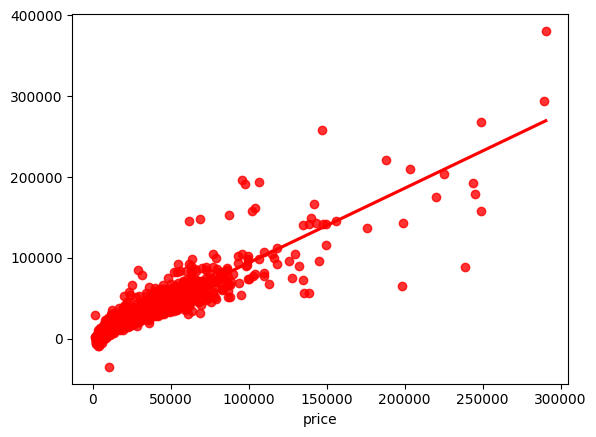

In [23]:
sns.regplot(x=y_test,y=y_pred,ci=None,color ='red');

Difference between Actual and Predicted Values

In [24]:
pred_df=pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred,'Difference':y_test-y_pred})
pred_df

,Actual Value,Predicted Value,Difference
39751,8850,6820.115828,2029.884172
20003,13900,17485.483552,-3585.483552
15477,13490,13168.285399,321.714601
9106,5400,2120.235443,3279.764557
7959,9800,10924.711665,-1124.711665
...,...,...,...
23730,5950,7163.207713,-1213.207713
39611,9999,10163.845217,-164.845217
13184,11330,12008.847025,-678.847025
18543,8450,10083.316378,-1633.316378
